<a href="https://colab.research.google.com/github/TheFox272/MI201/blob/main/MI201_rapport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MI201 : Attaque de réseau de neurone parr ajout d'un bruit (ciblé ou non)

L'objectif de ce projet est de perturber un réseau de neurones, déjà entrainé et performant, en ajoutant un bruit très faible aux images qu'il prend en entrée.

## Introduction : données et score

On dispose d'une base de données de ms coco, comprenant une dizaine d'images. Chargeons les :

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=fb6711b945ee4653e82801ada7ed955714bb662c0bdc25d344c194e847f97541
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import wget, os, zipfile
from io import BytesIO
import torch
import torchvision

if not os.path.isfile("data"):
  url = "https://github.com/TheFox272/MI201/raw/main/coco/coco.zip"
  # Télécharger le fichier ZIP depuis l'URL
  archive_path = wget.download(url)
  # Spécifier le dossier d'extraction
  dossier_extraction = "./data"
  # Créer le dossier d'extraction s'il n'existe pas
  os.makedirs(dossier_extraction, exist_ok=True)
  # Extraire le contenu de l'archive
  with zipfile.ZipFile(archive_path, 'r') as archive:
      archive.extractall(dossier_extraction)
  # Supprimer le fichier ZIP après l'extraction
  os.remove(archive_path)

os.chdir("./data")
im1 = torchvision.io.read_image("217730183_8f58409e7c_z.jpg").float() / 255
im2 = torchvision.io.read_image("541870527_8fe599ec04_z.jpg").float() / 255
im3 = torchvision.io.read_image("2124681469_7ee4868747_z.jpg", mode=torchvision.io.ImageReadMode.RGB).float() / 255
im4 = torchvision.io.read_image("2711568708_89f2308b85_z.jpg").float() / 255
im5 = torchvision.io.read_image("2928196999_acd5471d23_z.jpg").float() / 255
im6 = torchvision.io.read_image("3016145160_497da1b387_z.jpg").float() / 255
im7 = torchvision.io.read_image("4683642953_2eeda0820e_z.jpg").float() / 255
im8 = torchvision.io.read_image("6911037487_cc68a9d5a4_z.jpg").float() / 255
im9 = torchvision.io.read_image("8139728801_60c233660e_z.jpg").float() / 255
os.chdir("../")

im1 = torch.nn.functional.interpolate(im1.unsqueeze(0), size=520)[0]
im2 = torch.nn.functional.interpolate(im2.unsqueeze(0), size=520)[0]
im3 = torch.nn.functional.interpolate(im3.unsqueeze(0), size=520)[0]
im4 = torch.nn.functional.interpolate(im4.unsqueeze(0), size=520)[0]
im5 = torch.nn.functional.interpolate(im5.unsqueeze(0), size=520)[0]
im6 = torch.nn.functional.interpolate(im6.unsqueeze(0), size=520)[0]
im7 = torch.nn.functional.interpolate(im7.unsqueeze(0), size=520)[0]
im8 = torch.nn.functional.interpolate(im8.unsqueeze(0), size=520)[0]
im9 = torch.nn.functional.interpolate(im9.unsqueeze(0), size=520)[0]

images =  [im1, im2, im3, im4, im5, im6, im7, im8, im9]

On cherche à écrire une fonction permettant d'évaluer notre générateur de bruit. Il nous faut donc d'abord une fonction de score, qui prendra en entrée le bruit, la prédiction de notre modèle d'IA sur l'image d'origine, et sa prédiction sur l'image bruitée. Pour cela on va effectuer les calculs suivants :

\begin{align}
||\text{noise}||_2 &= \frac{||\text{noise}_R||_2 + ||\text{noise}_G||_2 + ||\text{noise}_B||_2}{3}\\
\text{score} &= ||z - z_{noise}||_2 - ||\text{noise}||_2 \cdot K
\end{align}

où $K$ est le facteur d'impact de la norme du bruit, à déterminer empiriquement. Nous lui donneront la valeur de 2000.

In [19]:
def score(noise, original_prediction, new_prediction, noise_factor=2000):
    noise_norm = torch.mean(torch.linalg.matrix_norm(noise))   # le bruit est une matrice 3*512*512 (R,G,B), on fait donc la moyenne des normes 2 sur chaque sous-matrice
    prediction_diff_norm = torch.linalg.matrix_norm((original_prediction - new_prediction).double())   # on calcul ici simplement la norme 2 de la différence
    return noise_norm, prediction_diff_norm

On peut maintenant coder la fonction d'évalution. Celle-ci consistera

algorithme de segmentation sémantique disponible dans le catalogue torchvision

In [7]:
# Build original prediction
x = torch.stack(images, dim=0)

W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W)
net = net.cuda()

with torch.no_grad():
  x_transformed = (W.transforms())(x).cuda()
  z_original = net(x_transformed)["out"][:, [0, 8, 12, 15], :, :]
  _, z_original = z_original.max(1)
torch.save(z_original, "data/z_original.t")



In [20]:
import matplotlib.pyplot as plt

def evaluator(noise_function):
  x = torch.stack(images, dim=0)

  W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
  net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W)
  net = net.cuda()

  z_original = torch.load("data/z_original.t")

  images_noisy = [noise_function(image) for image in images]
  x_noisy = torch.stack(images_noisy, dim=0)

  with torch.no_grad():
    x_noisy_transformed = (W.transforms())(x_noisy).cuda()
    z_noisy = net(x_noisy_transformed)["out"][:, [0, 8, 12, 15], :, :]
    _, z_noisy = z_noisy.max(1)


  total_score = 0
  fig, axs = plt.subplots(9, 6, figsize=(20, 20))

  for i in range(9):
    original_image = images[i].cpu().numpy().transpose(1, 2, 0)
    original_prediction = z_original[i].cpu().numpy()
    noise = x_noisy[i] - x[i]
    noisy_image = images_noisy[i].cpu().numpy().transpose(1, 2, 0)
    noisy_prediction = z_noisy[i].cpu().numpy()

    axs[i, 0].imshow(original_image)

    axs[i, 1].imshow(original_prediction)

    axs[i, 2].imshow(noise.cpu().numpy().transpose(1, 2, 0))

    axs[i, 3].imshow(noisy_image)

    axs[i, 4].imshow(noisy_prediction)

    noise_norm, actual_score = score(noise, z_original[i], z_noisy[i])
    total_score += actual_score

    axs[i, 5].axis('off')
    axs[i, 5].text(0, 0.5, f"Noise norm = {noise_norm}\nScore = {actual_score}", fontsize=10)

  plt.show()

In [9]:
max_noise = 4/255

def gaussian_noise(image):
    noise = torch.randn_like(image)
    noise *= max_noise / torch.mean(torch.linalg.matrix_norm(noise))
    return image + noise

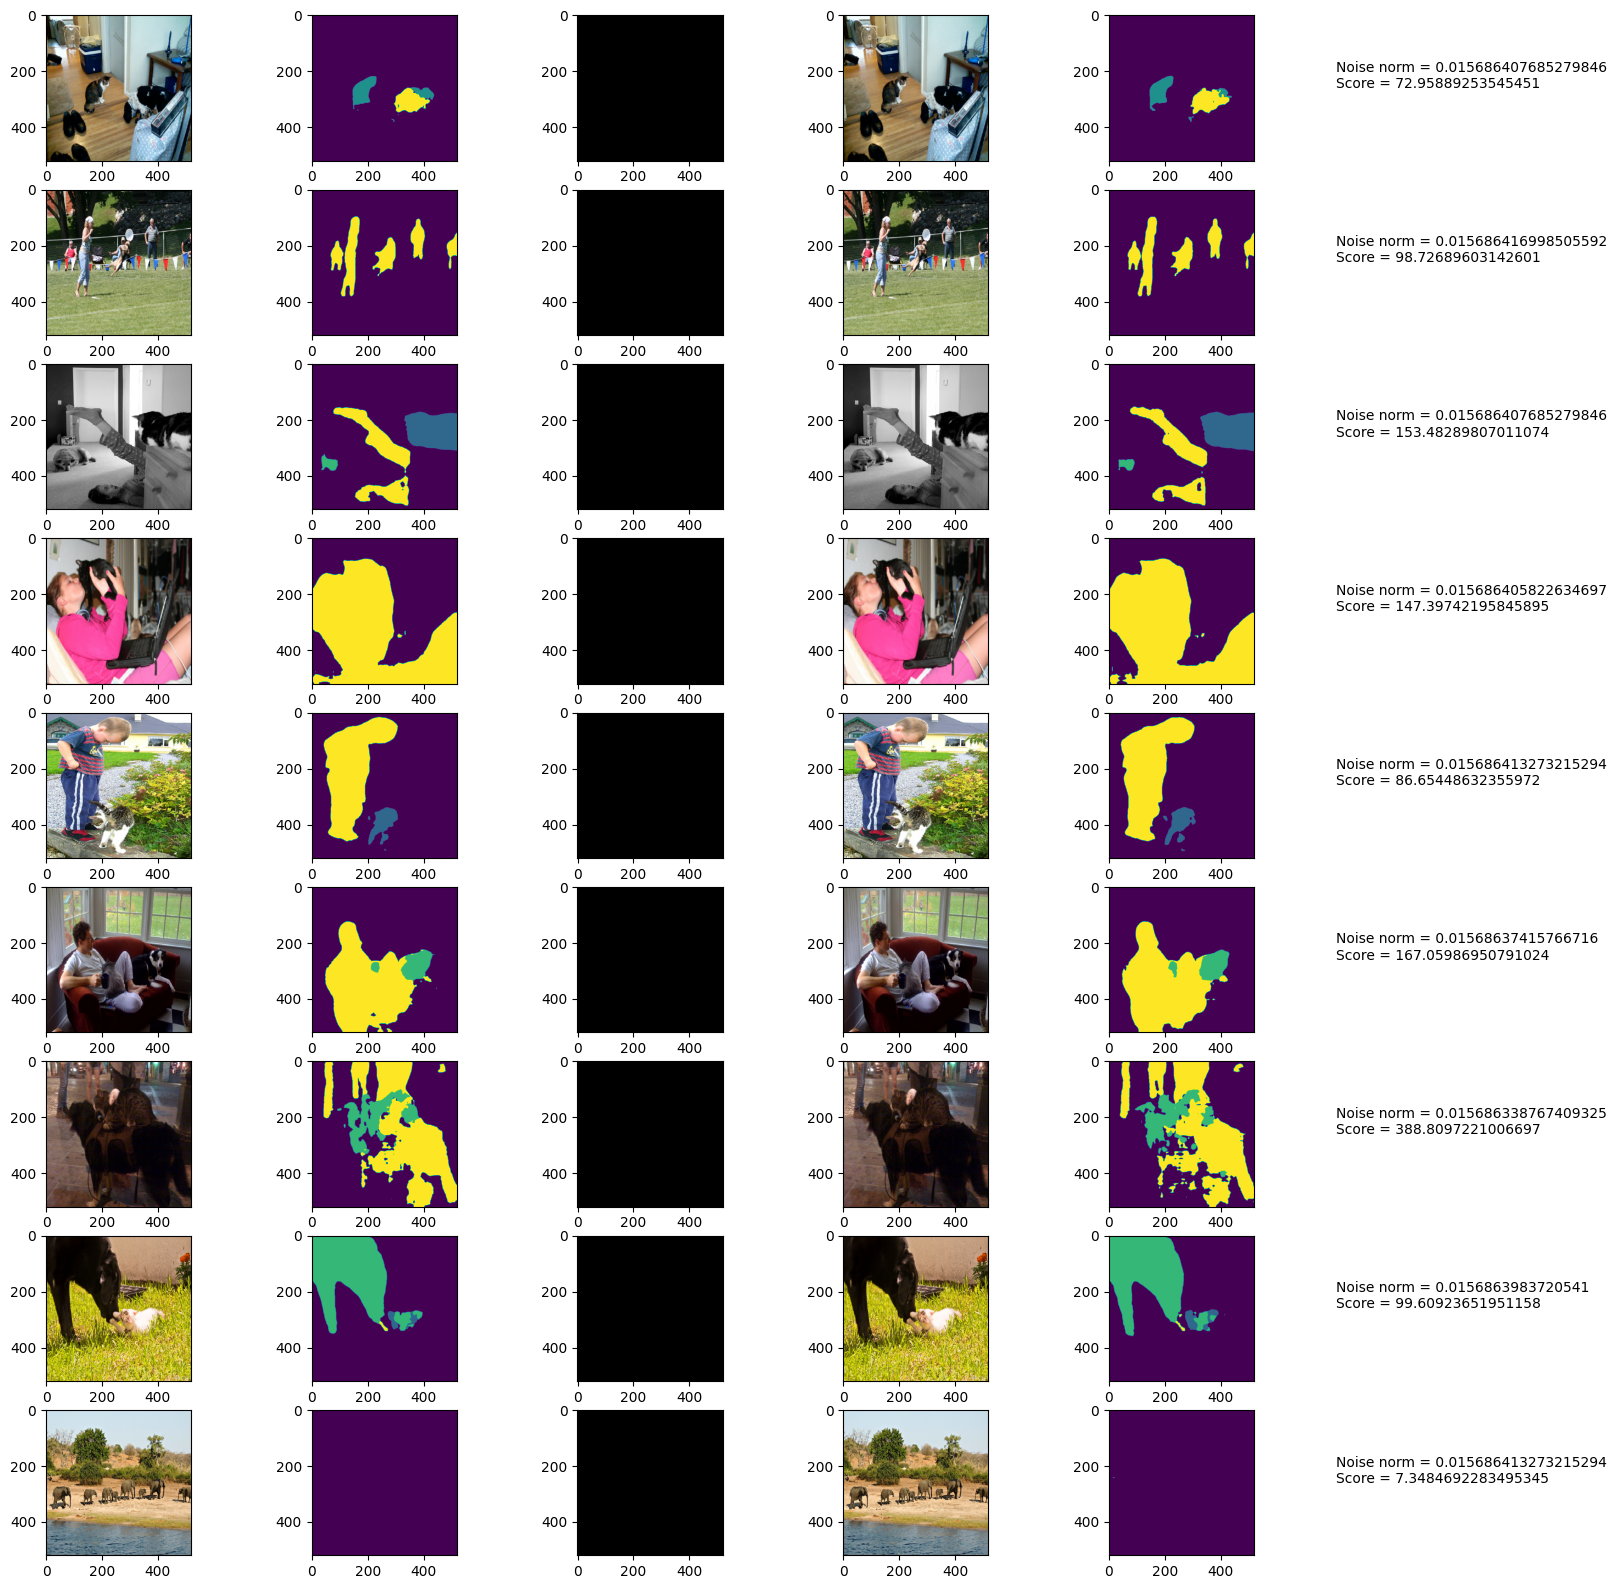

In [21]:
evaluator(gaussian_noise)